<a href="https://colab.research.google.com/github/sepehrsardooeinasab/Face_Boundry_and_Facial_Landmark_Detection/blob/master/part1_face_boundary_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face boundry detection

## Config google collab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Global variables

In [ ]:
BASE_PATH = r'/content/drive/MyDrive/CV2022/'
NEW_WIDTH_HEIGHT = 224
GENERATOR_SIZE = 128
MINI_BATCH_SIZE = 64
EPOCHS = 5
SEED = 0

## Unzip data

In [ ]:
!unzip -qq {BASE_PATH}WiderSelected.zip -d {BASE_PATH}

replace /content/drive/MyDrive/CV2022/WiderSelected/annotations.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Import neccessary packages

In [ ]:
import os
import re
import cv2
import logging
import numpy as np
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout

## Set seeds

In [ ]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.keras.utils.set_random_seed(seed)

set_seeds(SEED)

## Display setting

In [ ]:
sns.set(rc={'figure.figsize':(15, 8)})
tf.get_logger().setLevel(logging.ERROR)
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
sns.set_style("whitegrid", {'axes.grid' : False, 'axes.spines.left': True,
                            'axes.spines.bottom': True, 'axes.spines.top': True,
                            'axes.spines.right': True})

## OpenCV selective search

In [ ]:
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

##  Calculate Intersection over union

In [ ]:
def calculate_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

## Train, Validation and Test split

In [ ]:
def num_images_faces():
    num_images = 0
    num_faces = 0
    
    annotations_text = open(BASE_PATH + 'WiderSelected/annotations.txt')
    lines = annotations_text.readlines()
    annotations_text.close()
    
    for line in lines:
        if re.match(r'^\d+--*', line.strip()):
            num_images += 1
        elif len(line.strip().split())==1:
            num_faces += int(line.strip())
    
    return num_images, num_faces

In [ ]:
num_images, num_faces = num_images_faces()

RANGE_TRAIN = [0, int(0.8*num_images)]
RANGE_VAL = [int(0.8*num_images), int(0.82*num_images)]
RANGE_TEST = [int(0.82*num_images), int(num_images)]

print("number of images in data set:", num_images, "\nnumber of faces in data set:", num_faces, "\n")
print("Range train: {:0>4d} - {:0>4d}".format(RANGE_TRAIN[0], RANGE_TRAIN[1]))
print("Range val:   {:0>4d} - {:0>4d}".format(RANGE_VAL[0], RANGE_VAL[1]))
print("Range test:  {:0>4d} - {:0>4d}".format(RANGE_TEST[0], RANGE_TEST[1]))

number of images in data set: 4275 
number of faces in data set: 6249 

Range train: 0000 - 3420
Range val:   3420 - 3505
Range test:  3505 - 4275


## Make set function

In [ ]:
def make_set(start_index, end_index):
    annotations_text = open(BASE_PATH + "WiderSelected/annotations.txt", 'r')
    lines = annotations_text.readlines()
    annotations_text.close()
    image_counter = 0
    pointer = 0
    images = []
    labels = []
    
    while pointer <= len(lines):
        if start_index <= image_counter < end_index:
            path_image = lines[pointer].strip()
            image = cv2.imread(BASE_PATH + "WiderSelected/train/" + path_image)
            current_heigth, current_width = image.shape[0], image.shape[1]
            resized_image = cv2.resize(image, (NEW_WIDTH_HEIGHT, NEW_WIDTH_HEIGHT), (NEW_WIDTH_HEIGHT/current_width),
                                       (NEW_WIDTH_HEIGHT/current_heigth), interpolation=cv2.INTER_CUBIC)
            pointer += 1
            num_faces = int(lines[pointer])
            pointer += 1
            
            resized_bbs = []
            for num_face in range(num_faces):
                face_bbs = lines[pointer].split()[:4]
                x, y, w, h = int(face_bbs[0]), int(face_bbs[1]), int(face_bbs[2]), int(face_bbs[3])
                x, y, w, h = (int(x * NEW_WIDTH_HEIGHT / current_width), int(y * NEW_WIDTH_HEIGHT / current_heigth),
                              int(w * NEW_WIDTH_HEIGHT / current_width), int(h * NEW_WIDTH_HEIGHT / current_heigth))
                resized_bbs.append({"x1":x, "x2":x+w, "y1":y, "y2":y+h})
                timage = resized_image[y:y+h, x:x+w]
                resized = cv2.resize(timage, (NEW_WIDTH_HEIGHT, NEW_WIDTH_HEIGHT))
                images.append(resized)
                labels.append(1)
                pointer += 1
            
            ss.setBaseImage(resized_image)
            ss.switchToSelectiveSearchFast(base_k=50, inc_k=50, sigma=0.8)
            ss_results = ss.process()
            
            false_counter = 0
            for e, ss_result in enumerate(ss_results):
                if e < 2000 and false_counter < 6:
                    for border in resized_bbs:
                        x, y, w, h = ss_result
                        iou = calculate_iou(border, {"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if iou < 0.4:
                            timage = resized_image[y:y+h, x:x+w]
                            resized = cv2.resize(timage, (NEW_WIDTH_HEIGHT, NEW_WIDTH_HEIGHT))
                            images.append(resized)
                            labels.append(0)
                            false_counter += 1            
        elif image_counter >= end_index:
            break    
        else:
            pointer += 1
            num_faces = int(lines[pointer])
            pointer += 1
            for i in range(num_faces):
                pointer += 1

        image_counter += 1

    X = np.array(images)
    Y = np.array(labels)
    return X, Y

## Vgg model

In [ ]:
vgg = VGG16(include_top=True, weights='imagenet')
for layer in vgg.layers[:-2]:
    layer.trainable = False
x = vgg.get_layer('fc2').output
x = Dense(1, activation='sigmoid')(x)
model = Model(vgg.input, x)
model.summary()

553476096/553467096 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

## Set optimizer, loss function and metrics

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy()
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

## Train data with custom fit

In [ ]:
history = []
X_val, Y_val = make_set(RANGE_VAL[0], RANGE_VAL[1])
X_val = X_val / 255.0
Y_val.resize((Y_val.shape[0], 1))
print("Size Validation:", X_val.shape[0])

pbar_epoch = tqdm(total=EPOCHS)
pbar_part_data = tqdm(total=EPOCHS)
pbar_mini_batch = tqdm(total=EPOCHS)
best_val_acc = 0

for epoch in range(EPOCHS):
    pbar_epoch.set_description_str(desc="Epoch {}".format(epoch))
    number_parts_data = int((RANGE_TRAIN[1]-RANGE_TRAIN[0]) / GENERATOR_SIZE)
    pbar_part_data.reset(number_parts_data)
    
    for nth_part_data in range(number_parts_data):
        pbar_part_data.set_description_str(desc="Part {} Data".format(nth_part_data))
        X_train, Y_train = make_set(RANGE_TRAIN[0]+(GENERATOR_SIZE*nth_part_data),
                                    RANGE_TRAIN[0]+(GENERATOR_SIZE*(nth_part_data+1)))
        X_train = X_train / 255.0
        number_mini_batches = int(len(X_train)/MINI_BATCH_SIZE)
        pbar_mini_batch.reset(number_mini_batches)
        
        for mini_batch_number in range(number_mini_batches):
            pbar_mini_batch.set_description_str(desc="Mini Batch {}".format(mini_batch_number))
            X = X_train[MINI_BATCH_SIZE*mini_batch_number : MINI_BATCH_SIZE*(mini_batch_number+1), :, :, :]
            Y = Y_train[MINI_BATCH_SIZE*mini_batch_number : MINI_BATCH_SIZE*(mini_batch_number+1)]
            Y.resize((Y.shape[0], 1))
        
            with tf.GradientTape() as tape:
                logits = model(X, training=True)
                loss_value = loss_fn(Y, logits)
        
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            train_acc_metric.update_state(Y, logits)
            train_acc = train_acc_metric.result()
            train_acc_metric.reset_states()
            pbar_mini_batch.update()
                
        pbar_part_data.update()
        
    val_logits = model(X_val, training=False)
    loss_value_val = loss_fn(Y_val, val_logits)
    val_acc_metric.update_state(Y_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Training   loss epoch %d: %.4f" %(epoch, float(loss_value)))
    print("Training   acc  epoch %d: %.4f" %(epoch, float(train_acc)))
    print("Validation loss epoch %d: %.4f" %(epoch, float(loss_value_val)))
    print("Validation acc  epoch %d: %.4f" %(epoch, float(val_acc)))
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model.save(BASE_PATH + "Models/VGG16_BB")
        print("Best Validation Accuracy. Model Saved.\n")
    else:
        print("")
        
    history.append({'loss':loss_value, 'acc':train_acc, 'val_loss':loss_value_val, 'val_acc':val_acc})
    pbar_epoch.update()

Size Validation: 151


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Training   loss epoch 0: 0.4910
Training   acc  epoch 0: 0.8281
Validation loss epoch 0: 0.3772
Validation acc  epoch 0: 0.8344
Best Validation Accuracy. Model Saved.

Training   loss epoch 1: 0.4171
Training   acc  epoch 1: 0.8594
Validation loss epoch 1: 0.3211
Validation acc  epoch 1: 0.8411
Best Validation Accuracy. Model Saved.

Training   loss epoch 2: 0.3467
Training   acc  epoch 2: 0.8438
Validation loss epoch 2: 0.3148
Validation acc  epoch 2: 0.8742
Best Validation Accuracy. Model Saved.

Training   loss epoch 3: 0.3464
Training   acc  epoch 3: 0.8906
Validation loss epoch 3: 0.2843
Validation acc  epoch 3: 0.8609

Training   loss epoch 4: 0.3417
Training   acc  epoch 4: 0.8438
Validation loss epoch 4: 0.2403
Validation acc  epoch 4: 0.9007
Best Validation Accuracy. Model Saved.



## Plot History

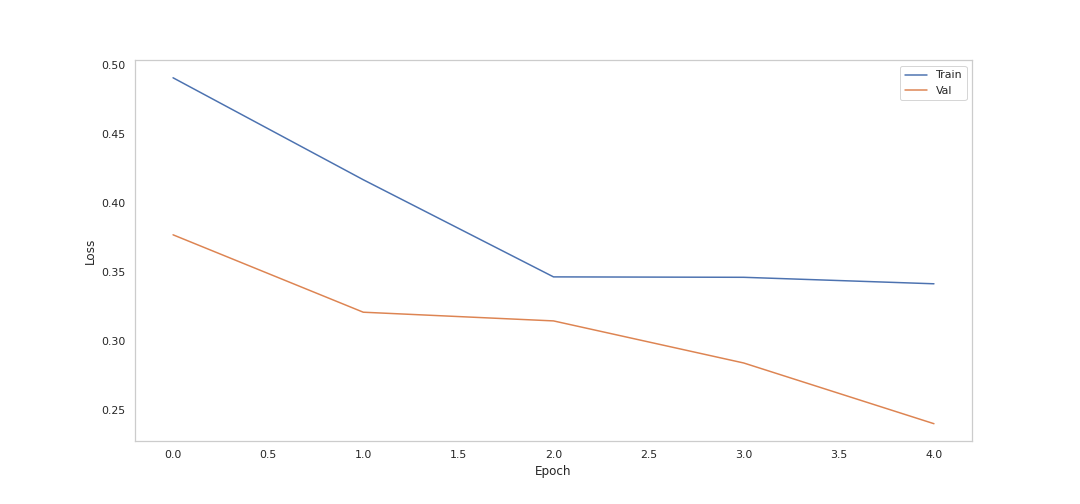

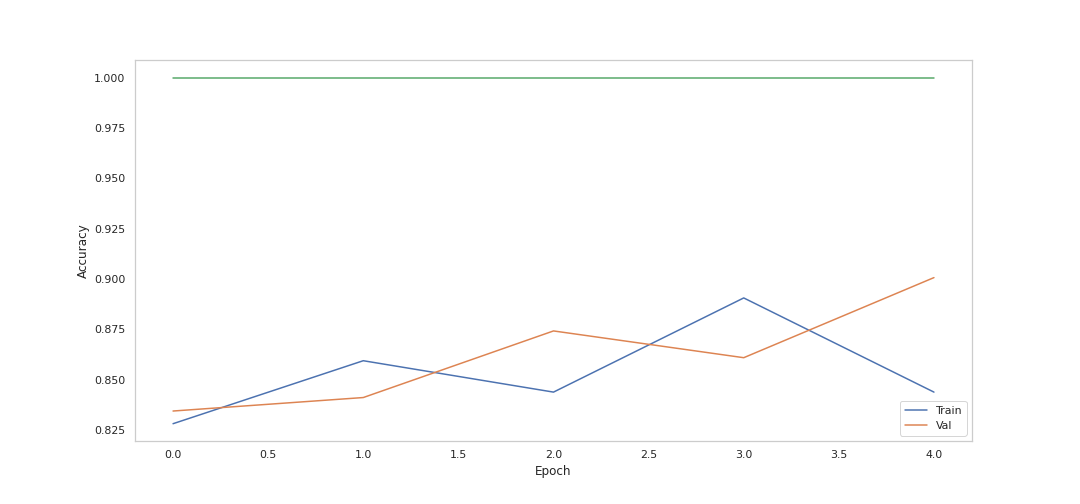

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))    
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.plot(np.arange(len(history)), np.array([history[i]['loss'] for i in range(len(history))]), label='Train')
ax.plot(np.arange(len(history)), np.array([history[i]['val_loss'] for i in range(len(history))]), label='Val')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(15, 7))    
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
ax.plot(np.arange(len(history)), np.array([history[i]['acc'] for i in range(len(history))]), label='Train')
ax.plot(np.arange(len(history)), np.array([history[i]['val_acc'] for i in range(len(history))]), label='Val')
ax.plot(np.arange(len(history)), np.ones(len(history)))
plt.legend()
plt.show()

## Test an image

In [ ]:
model = load_model(BASE_PATH + "Models/VGG16_BB")

In [ ]:
def test_image(image_index):
    annotations_text = open(BASE_PATH + "WiderSelected/annotations.txt", 'r')
    lines = annotations_text.readlines()
    annotations_text.close()
    image_counter = 0
    pointer = 0
    
    while pointer<=len(lines):
        if image_index==image_counter:
            path_image = lines[pointer].strip()
            image = cv2.imread(BASE_PATH + "WiderSelected/train/" + path_image)
            current_heigth, current_width = image.shape[0], image.shape[1]
            resized_image = cv2.resize(image, (NEW_WIDTH_HEIGHT, NEW_WIDTH_HEIGHT), (NEW_WIDTH_HEIGHT/current_width),
                                       (NEW_WIDTH_HEIGHT/current_heigth), interpolation=cv2.INTER_CUBIC)  
        elif image_counter > image_index:
            break
        else:
            pointer += 1
            num_faces = int(lines[pointer])
            pointer += 1
            for i in range(num_faces):
                pointer += 1
                
        image_counter += 1
        
    ss.setBaseImage(resized_image)
    ss.switchToSelectiveSearchFast()
    ss_results = ss.process()
    resized_image_copy = resized_image.copy() / 255.0
    
    bbs = []
    for i, result in enumerate(ss_results):
        if i < 500:
            x, y, w, h = result
            timage = resized_image_copy[y:y+h, x:x+w]
            resized = cv2.resize(timage, (NEW_WIDTH_HEIGHT, NEW_WIDTH_HEIGHT))
            resized = np.expand_dims(resized, axis=0)
            predicted = model.predict(resized)
            if (predicted[0] > 0.7):
                bbs.append([x, y, w, h])

    best_bbs = []
    flag = 0
    for i, box1 in enumerate(bbs):
        x1, y1, w1, h1 = box1
        for box2 in bbs[i+1:]:
            x2, y2, w2, h2 = box2
            if calculate_iou({"x1":x1, "x2":x1+w1, "y1":y1, "y2":y1+h1},
                             {"x1":x2, "x2":x2+w2, "y1":y2, "y2":y2+h2}) > 0.3:
                flag = 1
        if flag == 0:
            best_bbs.append(box1)
        flag = 0

    for box in best_bbs:
        x, y, w, h = box
        cv2.rectangle(resized_image_copy, (x,y), (x+w,y+h), (0,0,1), 1, cv2.LINE_AA)
    
    plt.imshow(resized_image_copy[:,:,::-1])
    plt.show()

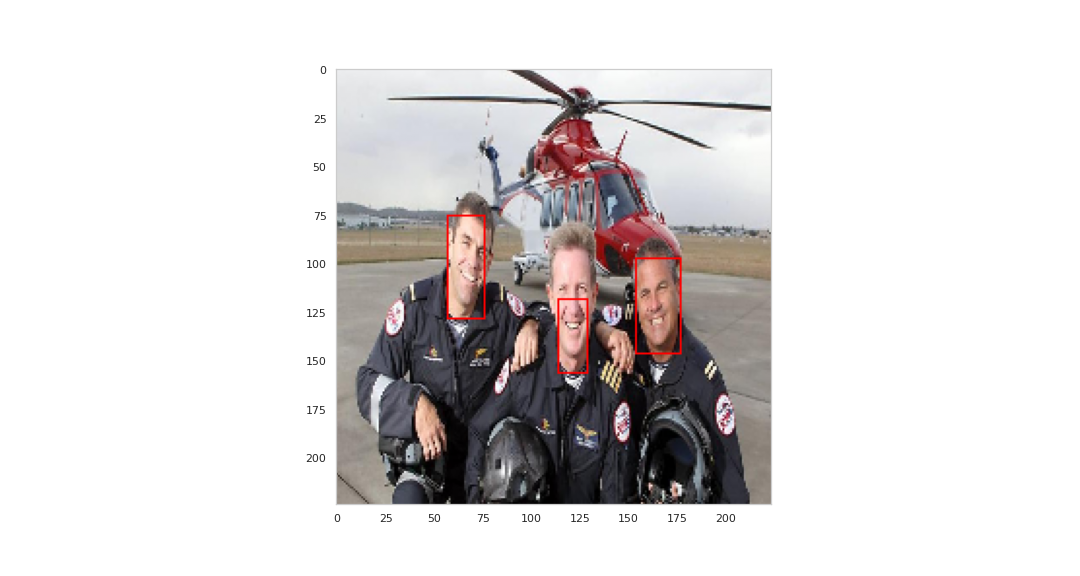

In [ ]:
test_image(RANGE_TEST[0]+25)